# Data Preparation

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from ast import literal_eval

### Load Data Sets

In [2]:
# Read the datasets with movie features
metadata = pd.read_csv('/Users/dorislin/Desktop/movie rating predictor/the-movies-dataset/movies_metadata.csv', parse_dates = ['release_date'])
credits =  pd.read_csv('/Users/dorislin/Desktop/movie rating predictor/the-movies-dataset/credits.csv')
keywords =  pd.read_csv('/Users/dorislin/Desktop/movie rating predictor/the-movies-dataset/keywords.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Read the rating datasets
ratings = pd.read_csv('/Users/dorislin/Desktop/movie rating predictor/the-movies-dataset/ratings.csv')
links = pd.read_csv('/Users/dorislin/Desktop/movie rating predictor/the-movies-dataset/links.csv')

### Merge Data Sets
The information of movie features are stored in metadata and credits datasets; while the rating information are in ratings and links datasets. Before merging all data together to do further analysis, few steps are taken to facilitate the merge process:

#### Combine datasets with movie feautres using 'id' as a shared column

In [4]:
# Swap values between 'id' and 'release_date' for misplaced observations
swap_condition = metadata['id'].str.contains('-') == True
ary = np.where(swap_condition,[metadata.release_date,metadata.id],[metadata.id,metadata.release_date])
metadata.id = ary[0]
metadata.release_date = ary[1]

# Convert the data type of 'id' from string to int
metadata['id'] = metadata['id'].astype(int)

# Merge datasets with movie features with the key colum 'id'
movie = metadata.merge(credits.merge(keywords, on='id'), on='id')

#### Get weighted scores from  datasets with rating records

In [5]:
# Initial Examination
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


Currently, each observation is a rating record given by a user to a movie. From here, I compute below information in order to get the target variable, weighted_rating.

- 'average_rating': By dividing the sum of rating by the vote number for each movie, we'll get our target variable for this project.
- 'votes_per_user': By counting how many votes each user gives, the number helps to identify frequent raters.
- 'votes_per_movie': By counting how many votes each movie receives, the number helps to identify the most-voted movie.

In [6]:
# average_rating
ratings['average_rating'] = ratings.groupby('movieId')['rating'].transform(np.mean)
# votes_per_user
ratings['votes_per_user'] = ratings.groupby('userId')['movieId'].transform('count')
# votes_per_movie
ratings['votes_per_movie'] = ratings.groupby('movieId')['userId'].transform('count')

In [7]:
# merge ratings with links in order to acquire movieId column
ratings_clean = pd.merge(ratings,links,on='movieId')
# ignore the user data for now, keep one column for one movie rating record
ratings_clean = ratings_clean.drop_duplicates('tmdbId')[['tmdbId','votes_per_movie','average_rating']]
# prepare for the merge
ratings_clean  = ratings_clean.loc[pd.notnull(ratings_clean['tmdbId']) != False]

In [8]:
# prepare for the combination
ratings_clean.rename(columns = {'tmdbId':'id'}, inplace = True)
ratings_clean = ratings_clean.astype({'id': 'int64'})

In [9]:
# merge the movie dateset with rating dataset
df_initial = pd.merge(ratings_clean,movie,on='id')
df_initial.shape

(45885, 29)

#### Computing our target variable: Weighted Rating, using IMDB Formula
- v: number of votes for the movie 
    - which is the value in column 'votes_per_movie'
- m: the minimum votes required to be listed in the chart
- R: average rating of the movie
    - which is the value in column 'average_rating'
- C: the mean rating of overall movies

In [10]:
# m is the minumum votes required to be listed in the chart
m = df_initial['votes_per_movie'].quantile(0.75)
m

67.0

In [11]:
# C is the mean rating across the whole report
C = df_initial['average_rating'].mean()
C

3.0588051892574892

In [12]:
# filter the movies qualified for the chart
df = df_initial[df_initial['votes_per_movie'] >= m]
df.shape

(11481, 29)

In [13]:
# calculate weighted_rating
def weighted_rating(x):
    v = x['votes_per_movie']
    R = x['average_rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [14]:
df['weighted_rating'] = df.apply(weighted_rating, axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Data Cleaning

In [15]:
# Get an initial feeling of the data
df.head()

,id,votes_per_movie,average_rating,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,...,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords,weighted_rating
0,197,66512,4.016057,False,NaN,72000000,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,tt0112573,en,...,Released,Every man dies. Not every man truly lives.,Braveheart,False,7.7,3404.0,"[{'cast_id': 5, 'character': 'William Wallace'...","[{'credit_id': '52fe4225c3a36847f80079c1', 'de...","[{'id': 30, 'name': 'individual'}, {'id': 388,...",4.015094
1,10474,4967,3.595933,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,tt0112461,en,...,Released,The true story of the death of innocence and t...,The Basketball Diaries,False,7.2,472.0,"[{'cast_id': 9, 'character': 'Jim Carroll', 'c...","[{'credit_id': '52fe43779251416c7501167d', 'de...","[{'id': 6075, 'name': 'sport'}, {'id': 6496, '...",3.588784
2,238,57070,4.339811,False,"{'id': 230, 'name': 'The Godfather Collection'...",6000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",http://www.thegodfather.com/,tt0068646,en,...,Released,An offer you can't refuse.,The Godfather,False,8.5,6024.0,"[{'cast_id': 5, 'character': 'Don Vito Corleon...","[{'credit_id': '52fe422bc3a36847f80093db', 'de...","[{'id': 131, 'name': 'italy'}, {'id': 699, 'na...",4.338309
3,240,36679,4.263475,False,"{'id': 230, 'name': 'The Godfather Collection'...",13000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,tt0071562,en,...,Released,"I don't feel I have to wipe everybody out, Tom...",The Godfather: Part II,False,8.3,3418.0,"[{'cast_id': 8, 'character': 'Don Michael Corl...","[{'credit_id': '52fe422bc3a36847f80094dd', 'de...","[{'id': 700, 'name': 'italo-american'}, {'id':...",4.261279
4,207,25752,3.912803,False,NaN,16400000,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0097165,en,...,Released,He was their inspiration. He made their lives ...,Dead Poets Society,False,8.1,2786.0,"[{'cast_id': 3, 'character': 'John Keating', '...","[{'credit_id': '52fe4227c3a36847f8008045', 'de...","[{'id': 30, 'name': 'individual'}, {'id': 490,...",3.910587


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11481 entries, 0 to 24755
Data columns (total 30 columns):
id                       11481 non-null int64
votes_per_movie          11481 non-null int64
average_rating           11481 non-null float64
adult                    11481 non-null object
belongs_to_collection    2031 non-null object
budget                   11481 non-null object
genres                   11481 non-null object
homepage                 2636 non-null object
imdb_id                  11480 non-null object
original_language        11481 non-null object
original_title           11481 non-null object
overview                 11475 non-null object
popularity               11480 non-null object
poster_path              11478 non-null object
production_companies     11481 non-null object
production_countries     11481 non-null object
release_date             11481 non-null object
revenue                  11479 non-null float64
runtime                  11479 non-null float64

**Thought Process**
1. Identify columns that fit to the objectives of this project and remove irrelevant ones:
  - `identifiers`
    - id
    - title
  - `business-side`
    -   revenue
    -   budget
  - `plot`
    - belongs_to_collection
    - genres
    - keywords
  - `production-side`
    - runtime
    - release_date
    - original_language
    - production_companies
    - production_countries
  - `team`
    - cast
    - crew
  - `audience`
    - votes_per_movie

  - `target variable`
    - weighted_rating
    

2. Know which parts require detection of missing values and type conversion.

### Remove Duplicates and Irrelevant Data

In [17]:
# Remove the duplicates with identical values of 'id'
df.drop_duplicates(subset=['id'], inplace = True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
# Drop irrelevant data
to_keep_features = ['id','title','revenue','budget','belongs_to_collection','genres','keywords','runtime','release_date',
                   'original_language','production_companies','production_countries','cast','crew', 'votes_per_movie','weighted_rating']
df = df[to_keep_features]

In [19]:
print ('The shape of dataset:',df.shape)
print ('Columns include:',list(df.columns))

The shape of dataset: (11347, 16)
Columns include: ['id', 'title', 'revenue', 'budget', 'belongs_to_collection', 'genres', 'keywords', 'runtime', 'release_date', 'original_language', 'production_companies', 'production_countries', 'cast', 'crew', 'votes_per_movie', 'weighted_rating']


### Detect Missing Data

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11347 entries, 0 to 24755
Data columns (total 16 columns):
id                       11347 non-null int64
title                    11347 non-null object
revenue                  11347 non-null float64
budget                   11347 non-null object
belongs_to_collection    2010 non-null object
genres                   11347 non-null object
keywords                 11347 non-null object
runtime                  11347 non-null float64
release_date             11347 non-null object
original_language        11347 non-null object
production_companies     11347 non-null object
production_countries     11347 non-null object
cast                     11347 non-null object
crew                     11347 non-null object
votes_per_movie          11347 non-null int64
weighted_rating          11347 non-null float64
dtypes: float64(3), int64(2), object(11)
memory usage: 1.5+ MB


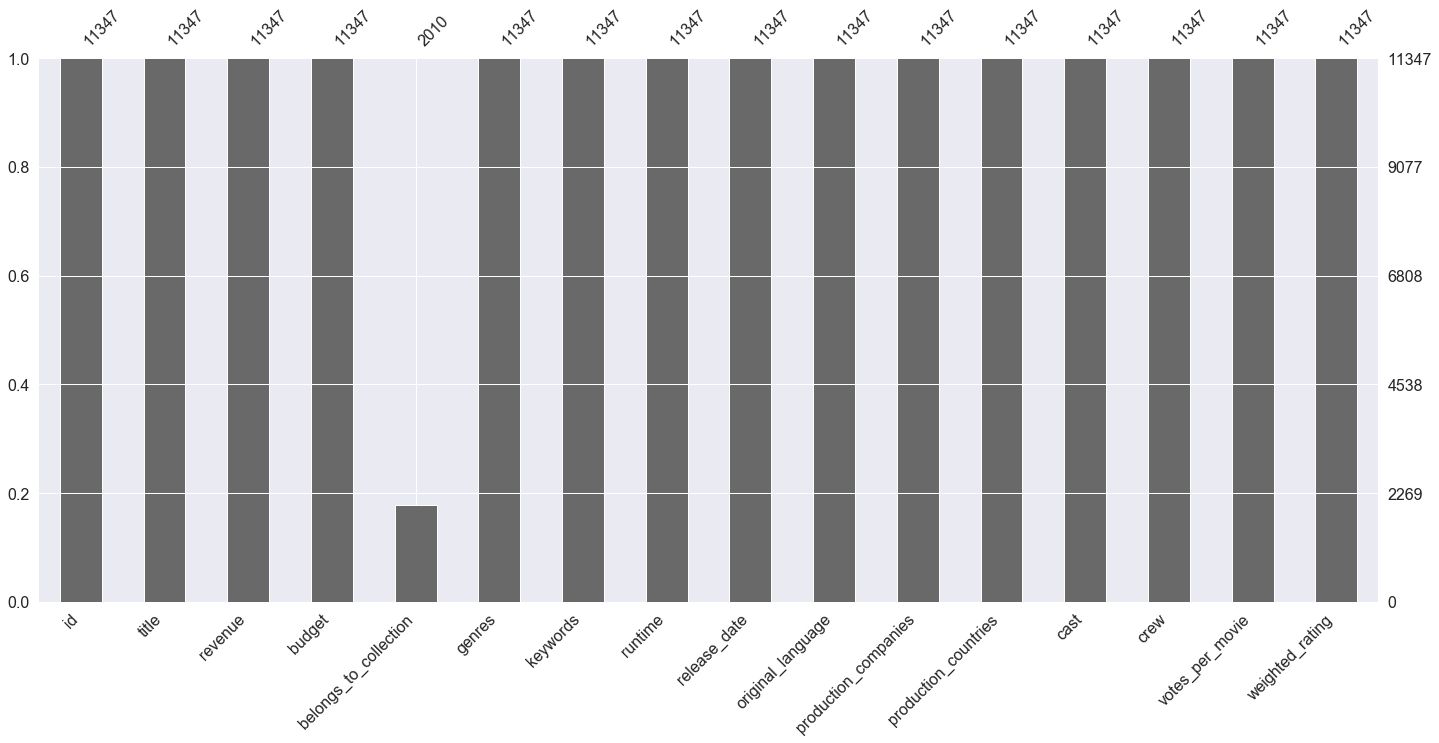

In [21]:
import missingno as msno
msno.bar(df)

**Thought Process**
1. Besides of 'belongs_to_collection' column, no obvious missing values observed. 
2. However, I found nonstandard missing values in column 'budget' and 'revenue' when looking closer into the data.

### Handling Missing data
After examination, I found that missing values in 'belongs_to_collection' indicate the movie has no sequence.

I used boolean logic to separate movies into two categories: belonging to a collection or without sequence, and compute 1 and 0 to them accordinly.

In [22]:
# Compute 0 for missing values (the movies without sequence)
df['belongs_to_collection'].fillna(0, inplace = True)
# Compute 1 for belonging to a collection
condition = df['belongs_to_collection'] != 0
df.loc[condition, 'belongs_to_collection'] = 1

### Nonstandard Missing data

In [23]:
# Closer look at observations with zero budget
df[df['budget'] == '0'].sample(5)

,id,title,revenue,budget,belongs_to_collection,genres,keywords,runtime,release_date,original_language,production_companies,production_countries,cast,crew,votes_per_movie,weighted_rating
1560,16306,Fantastic Planet,0.0,0,0,"[{'id': 16, 'name': 'Animation'}, {'id': 14, '...","[{'id': 2831, 'name': 'slavery'}, {'id': 4565,...",72.0,1973-05-01,fr,"[{'name': 'Krátký Film Praha', 'id': 2329}, {'...","[{'iso_3166_1': 'CZ', 'name': 'Czech Republic'...","[{'cast_id': 5, 'character': 'Tiwa (voice)', '...","[{'credit_id': '52fe46c39251416c75082a77', 'de...",1112,3.696726
12187,17956,"He Said, She Said",0.0,0,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 187056, 'name': 'woman director'}]",115.0,1991-02-22,en,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'cast_id': 3, 'character': 'Dan Hanson', 'cr...","[{'credit_id': '52fe47559251416c75095ac7', 'de...",209,2.887464
3724,33194,Xiu Xiu: The Sent-Down Girl,0.0,0,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10769, 'n...","[{'id': 293, 'name': 'female nudity'}, {'id': ...",99.0,1998-02-19,zh,[],"[{'iso_3166_1': 'CN', 'name': 'China'}, {'iso_...","[{'cast_id': 5, 'character': 'Wenxiu', 'credit...","[{'credit_id': '52fe45029251416c9102465b', 'de...",445,3.521367
9250,4972,The Green Butchers,0.0,0,0,"[{'id': 35, 'name': 'Comedy'}]","[{'id': 4452, 'name': 'butcher'}, {'id': 4457,...",100.0,2003-03-08,da,"[{'name': 'M&M Productions', 'id': 1789}]","[{'iso_3166_1': 'DK', 'name': 'Denmark'}]","[{'cast_id': 3, 'character': 'Astrid', 'credit...","[{'credit_id': '52fe43e9c3a36847f8077e1f', 'de...",200,3.531610
16218,18775,Demon Seed,0.0,0,0,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...","[{'id': 310, 'name': 'artificial intelligence'...",94.0,1977-04-07,en,"[{'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'cast_id': 1, 'character': 'Susan Harris', '...","[{'credit_id': '56f98704c3a3686a6100a9e5', 'de...",74,3.084680


In [24]:
# get the number of zero budget and zero revenue
print ('rows with zero budget:', df[df.budget == '0'].shape[0])
print ('rows with zero revenue:',df[df.revenue == 0].shape[0])

rows with zero budget: 5747
rows with zero revenue: 5622


**Thought Process**
1. Movies with zero budget often have zero revenue. Some of the movies are made by big companies, such as Warner Bros. and Columbia Pictures Corporation. Thus, zero in 'budget' and 'revenue' are more likely to represent missing values instead of low budget. 


2. Considering the cost of acquiring other data to compute missing values, and the potential bias caused by large volumns of zero, I decided to remove them from the dataset.

In [25]:
# Drop the row where revenue and budget both equal to 0
df = df[(df['budget'] != '0') & (df['revenue']!=0)].reset_index(drop = True)
print ("The shape of dataset",df.shape)

The shape of dataset (4532, 16)


### Convert Data Type

In [26]:
# convert'budget' column from object to integer data type
df['budget'] = df['budget'].astype('int64')

### Extract Nested Values
Columns including 'genres', 'procudtion_countries', 'production_companies', 'cast' and 'crew' are stored in JSON format. 

In [27]:
# extract director from the crew colum
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
df['director'] = df['crew'].apply(literal_eval).apply(get_director)
df.drop(columns=['crew'], inplace = True)

In [28]:
# Extract the main production country
df.production_countries = df.production_countries.fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df.production_countries = df.production_countries.apply(lambda x: "" if len(x) == 0 else x[0])

In [29]:
# Extract the main production company
df.production_companies = df.production_companies.fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df.production_companies = df.production_companies.apply(lambda x: "" if len(x) == 0 else x[0])

In [30]:
# Convert cast and only get the top 3 actors/actess
df.cast = df.cast.apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df.cast = df.cast.apply(lambda x: x[:3] if len(x) >=3 else x)

In [31]:
# Convert genres
df.genres = df.genres.apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [32]:
# Convert keywords
df.keywords = df.keywords.apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [33]:
# Rename the column
col_name = {'belongs_to_collection':'is_collection'}
df.rename(columns= col_name, inplace = True)

### Create New Variables

In [34]:
# Convert 'release_date' to datetime object 
df['release_date'] = pd.to_datetime(df['release_date'])

# Extract the 'month' and 'year' from 'release_date'
# Replace missing values with zero
df['month'] = df['release_date'].dt.month.astype(np.int64)
df['year'] = df['release_date'].dt.year.astype(np.int64)
df.drop(labels = 'release_date', axis = 1, inplace = True)

In [35]:
# Create two feautres, 'is_adapted' and 'is_YA', based on the keywords information

def is_adapted(series):
    adapted = ['based on novel',"based on children's book"]
    for i in adapted:
        if i in series:
            return 1
    return 0
df['is_adapted'] = df['keywords'].apply(is_adapted)
def is_YA(series):
    if 'teenager' in series:
        return 1
    else:
        return 0

df['is_YA'] = df['keywords'].apply(is_YA)

# Drop keywords column
df.drop(columns=['keywords'], inplace = True)

In [36]:
df.head()

,id,title,revenue,budget,is_collection,genres,runtime,original_language,production_companies,production_countries,cast,votes_per_movie,weighted_rating,director,month,year,is_adapted,is_YA
0,197,Braveheart,210000000.0,72000000,0,"[Action, Drama, History, War]",177.0,en,Icon Entertainment International,United States of America,"[Mel Gibson, Catherine McCormack, Sophie Marceau]",66512,4.015094,Mel Gibson,5,1995,0,0
1,238,The Godfather,245066411.0,6000000,1,"[Drama, Crime]",175.0,en,Paramount Pictures,United States of America,"[Marlon Brando, Al Pacino, James Caan]",57070,4.338309,Francis Ford Coppola,3,1972,0,0
2,240,The Godfather: Part II,47542841.0,13000000,1,"[Drama, Crime]",200.0,en,Paramount Pictures,United States of America,"[Al Pacino, Robert Duvall, Diane Keaton]",36679,4.261279,Francis Ford Coppola,12,1974,0,0
3,207,Dead Poets Society,235860116.0,16400000,0,[Drama],129.0,en,Touchstone Pictures,United States of America,"[Robin Williams, Ethan Hawke, Robert Sean Leon...",25752,3.910587,Peter Weir,6,1989,0,0
4,2108,The Breakfast Club,51525171.0,1000000,0,"[Comedy, Drama]",97.0,en,Universal Pictures,United States of America,"[Emilio Estevez, Anthony Michael Hall, Judd Ne...",26611,3.825622,John Hughes,2,1985,0,1


In [37]:
list(df.columns)

['id',
 'title',
 'revenue',
 'budget',
 'is_collection',
 'genres',
 'runtime',
 'original_language',
 'production_companies',
 'production_countries',
 'cast',
 'votes_per_movie',
 'weighted_rating',
 'director',
 'month',
 'year',
 'is_adapted',
 'is_YA']

# Exploratory Data Analysis

## Target Variable

### What's the frequency distribution of weighted rating per movie?

In [38]:
import statsmodels.api as sm
import scipy 

count    4532.000000
mean        3.239286
std         0.451904
min         1.256007
25%         2.944904
50%         3.261469
75%         3.564858
max         4.428007
Name: weighted_rating, dtype: float64

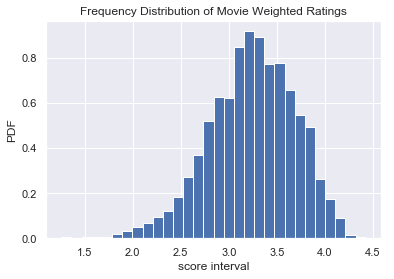

In [39]:
# plot a histogram to show the frequency distribution of weighted rating per movie
df['weighted_rating'].hist(bins=30, density = True) 
plt.title('Frequency Distribution of Movie Weighted Ratings')
plt.xlabel('score interval')
plt.ylabel('PDF')
df.weighted_rating.describe()

In [40]:
# Top 10 highly-scored movies
df[['title','weighted_rating','votes_per_movie']].sort_values(by = 'weighted_rating', ascending=False)[:10]

,title,weighted_rating,votes_per_movie
121,The Shawshank Redemption,4.428007,91082
1,The Godfather,4.338309,57070
457,The Usual Suspects,4.298787,59271
44,Schindler's List,4.265336,67662
2,The Godfather: Part II,4.261279,36679
195,Seven Samurai,4.249373,13994
7,Fight Club,4.229409,60024
482,Rear Window,4.228878,21335
104,One Flew Over the Cuckoo's Nest,4.227183,40103
1250,12 Angry Men,4.226578,16896


**Findings**
1. The average rating per movie is normally distributed, with majority of movies score in the middle (between 3-3.5) and less receiving high score above 4 and low below 2.

### How do users tend to rate a movie?

count    2.602429e+07
mean     3.528090e+00
std      1.065443e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

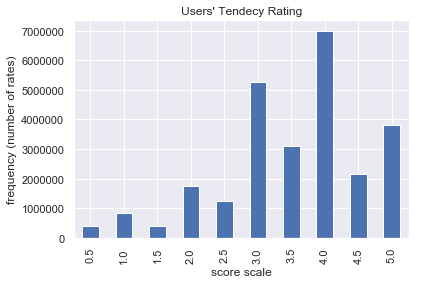

In [41]:
# Calculate the distribution of each rating interval, ranging from 0.5 to 5
ratings.groupby('rating').size().plot(kind = 'bar')
plt.title("Users' Tendecy Rating")
plt.xlabel('score scale')
plt.ylabel('frequency (number of rates)')

ratings.rating.describe()

**Findings**
1. Users are actually very generous, with more giving high scores (above 3) rather than low scores. 

## Numerical Variables

### How many ratings a movie receive?

count     4532.000000
mean      4522.890997
std       8346.593498
min         67.000000
25%        421.000000
50%       1334.500000
75%       4836.000000
max      91921.000000
Name: votes_per_movie, dtype: float64

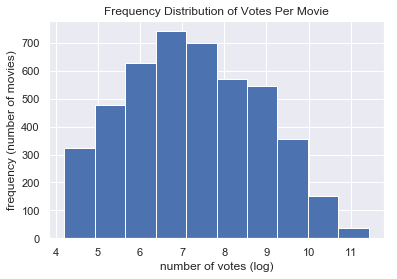

In [42]:
np.log(df.votes_per_movie).hist()
plt.title('Frequency Distribution of Votes Per Movie')
plt.xlabel('number of votes (log)')
plt.ylabel('frequency (number of movies)')

df.votes_per_movie.describe()

In [43]:
# Get the row of max value in votes_per_movie
df.loc[df['votes_per_movie'].idxmax()]['title']

'Forrest Gump'

**Findings**
- The distribution of votes per movie is skewed to the right, with mean (4522) larger than median (1334). There are outliers with large number of votes observed, which in our case, is 'Forrest Gump'.

### Money Matters: Could higher budget guarantee more positive revenue or ratings?
Budget as the key financing element that movie companies could decide in an early stage of a movie production. As the scatter plot showed that the movie budget has positive relationship with movie revenue. I'd like to also investigate whether high budget could also buy audience's preference.

In [44]:
# Correct budget values
def multiple_million(series):
    if len(str(series)) < 3:
        return series * 1000000
    else:
        return series
df['budget'] = df['budget'].apply(multiple_million)
df['revenue'] = df['revenue'].apply(multiple_million)

# Only four data whose budget values don't make sense left,
# I decided to manually check the info online and correct them accordingly
df.iloc[1453,3] = 11300000
df.iloc[4412,3] = 250000

### Higher budget often leads to higher revenue

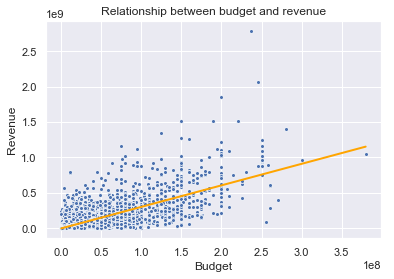

correlation:0.722, p-value0.000


In [45]:
# Plot the relationship between budget and revenue
sns.scatterplot(x = 'budget', y = 'revenue', data = df, s = 15)
plt.title('Relationship between budget and revenue')
plt.xlabel('Budget')
plt.ylabel('Revenue')

# perform a linear regrssion using np.polyfit()
slope, intercept = np.polyfit(df.budget, df.revenue, 1)
# Make theoretical line to plot
x = np.array([0, df.budget.max()])
y = slope * x + intercept
# add regression line
ax = plt.plot(x,y,c='orange',linewidth=2)

plt.show()

# Calculate correlation value
corr,p = scipy.stats.pearsonr(df.budget, df.revenue)
print ("correlation:%.3f, p-value%.3f" %(corr,p))

**Thought Process**

The strong correlation between budget and revenue suggested that they are very similar features. I would only keep 'budget' column when fitting a model later.

count    4.337000e+03
mean     3.681534e+07
std      4.229836e+07
min      1.000000e+06
25%      9.000000e+06
50%      2.200000e+07
75%      5.000000e+07
max      3.800000e+08
Name: budget, dtype: float64

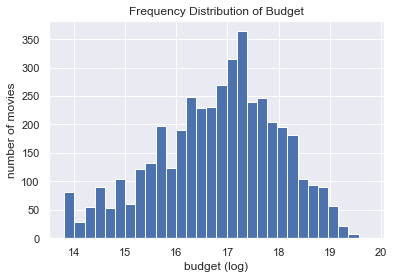

In [46]:
df = df[df['budget'] >= 1000000]

# log the budget value
ax = np.log(df.budget).hist(bins=30) 
plt.title('Frequency Distribution of Budget')
plt.xlabel('budget (log)')
plt.ylabel('number of movies')

df.budget.describe()

### Movie budget doesn't align with the audience preference

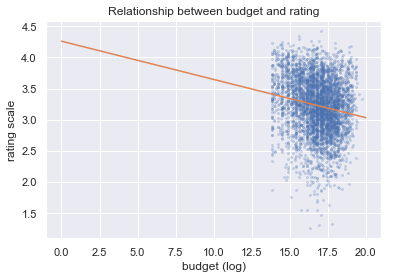

correlation:-0.165, p-value0.000


In [48]:
# plot the budget versus weighted rating
ax = plt.plot(np.log(df.budget),df.weighted_rating, 'o', markersize = 2, alpha = 0.2)
plt.title('Relationship between budget and rating')
plt.xlabel('budget (log)')
plt.ylabel('rating scale')

# perform a linear regrssion using np.polyfit()
slope, intercept = np.polyfit(np.log(df.budget), df.weighted_rating, 1)
# make theoretical line to plot
x = np.array([0, 20])
y = slope * x + intercept
# add regression line
ax = plt.plot(x,y)

plt.show()

# calculate correlation value
corr,p = scipy.stats.pearsonr(np.log(df.budget), df.weighted_rating)
print ("correlation:%.3f, p-value%.3f" %(corr,p))

### Production Sides: What's the influence of movie length and release timing  on ratings?

### Longer story attract audience more

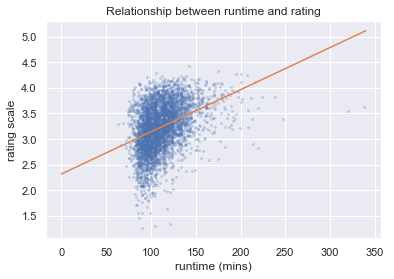

correlation:0.379, p-value0.000


In [49]:
# plot the revenue versus weighted rating
ax = plt.plot(df.runtime ,df.weighted_rating, 'o', markersize = 2, alpha = 0.2)
plt.title('Relationship between runtime and rating')
plt.xlabel('runtime (mins)')
plt.ylabel('rating scale')

# perform a linear regrssion using np.polyfit()
slope, intercept = np.polyfit(df.runtime, df.weighted_rating, 1)
# make theoretical line to plot
x = np.array([0, 340])
y = slope * x + intercept
# add regression line
ax = plt.plot(x,y)

plt.show()

# calculate correlation value
corr,p = scipy.stats.pearsonr(df.runtime, df.weighted_rating)
print ("correlation:%.3f, p-value%.3f" %(corr,p))
# 95% confidence in the relationship between features

### Timing seems to have less affect on movie ratings

Text(0, 0.5, 'ratings')

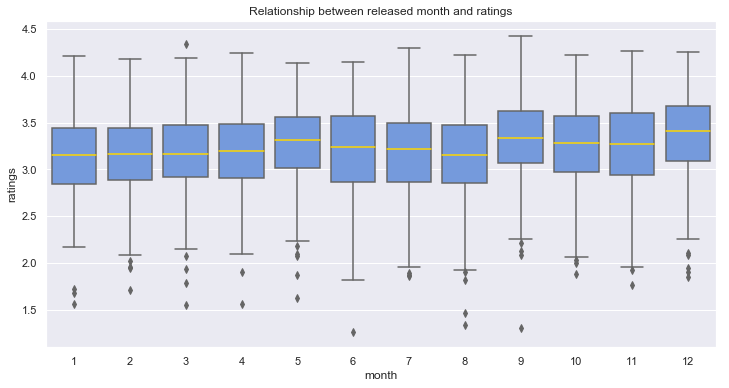

In [50]:
_ = plt.figure(figsize=(12,6))
_ = sns.boxplot(x = 'month', y = 'weighted_rating', data = df,color = 'cornflowerblue',medianprops={'color':'gold'} )
plt.title('Relationship between released month and ratings')
plt.xlabel('month')
plt.ylabel('ratings')

correlation:-0.152, p-value0.000


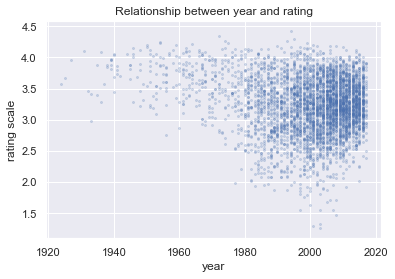

In [51]:
# plot the year versus weighted rating
ax = plt.plot(df.year ,df.weighted_rating, 'o', markersize = 2, alpha = 0.2)
plt.title('Relationship between year and rating')
plt.xlabel('year')
plt.ylabel('rating scale')

# Calculate correlation value
corr,p = scipy.stats.pearsonr(df.year ,df.weighted_rating)
print ("correlation:%.3f, p-value%.3f" %(corr,p))

**Thought Process**
1. The above graphs fail to capture the relationship between timing (month and year) and movie rating clearly. I would perform statistical tests to do more precise evaluation.

### Production Sides: What's the influence of production sites and studio on ratings?

In [52]:
df['production_countries'].value_counts(ascending = False)[:5]

United States of America    2985
United Kingdom               335
Germany                      173
France                       172
Canada                       169
Name: production_countries, dtype: int64

In [53]:
# select the top 5 countries with the most productions
top_countries = (df['production_countries'] == 'United States of America') | (df['production_countries']== 'United Kingdom') | (df['production_countries']== 'France') | (df['production_countries']== 'Germany')| (df['production_countries']== 'Canada')
countries_to_plot = df[top_countries]

#### Despite of being the movie-making capital, US's movies don't always get the highest rating score

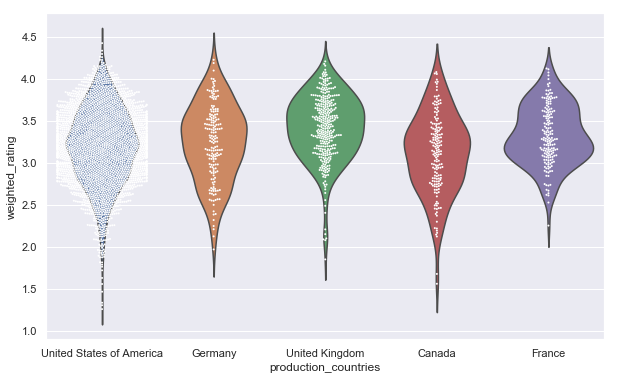

In [54]:
_ = plt.figure(figsize=(10,6))
_ = sns.violinplot(x="production_countries", y='weighted_rating', data = countries_to_plot, inner=None)
_ = sns.swarmplot(x="production_countries", y='weighted_rating', data = countries_to_plot, color="white", edgecolor="gray", size=2)

**Thought Process**
1. USA is the most dominant country. Its production numbers are way more than others and even nine times more than the second-ranking country, United Kingdom. 
2. Since the production numbers vary a lot. Only top 5 countries with the most productions are being considered when passing into the model.

#### Studio size doesn't guarantee the movie rating 
Major film studios, known as 'Big Six', including Universal Pictures, Paramount Pictures,  Twentieth Century Fox Film Corporation, Warner Bros., Columbia Pictures, Walt Disney Pictures, contributed the most of movie productions in the industry. Yes, suprisinly, their movie raitngs don't seem to be higher than other studios.

In [55]:
# ignore missing observations and take only the 10 companies with the most productions
companies = df[df['production_companies'].map(len) > 0]['production_companies'].value_counts()[:10]

Universal Pictures                        316
Paramount Pictures                        314
Twentieth Century Fox Film Corporation    233
Columbia Pictures                         203
New Line Cinema                           159
Walt Disney Pictures                      127
Warner Bros.                              102
Miramax Films                              83
Columbia Pictures Corporation              80
United Artists                             78
Name: production_companies, dtype: int64

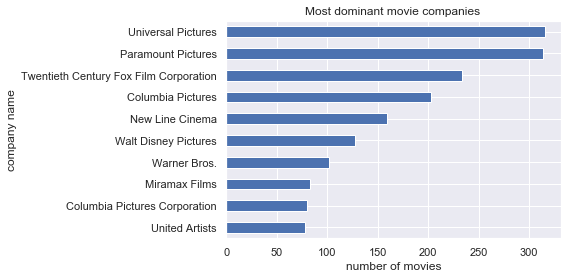

In [56]:
companies.sort_values().plot.barh()
plt.xlabel('number of movies')
plt.ylabel('company name')
plt.title('Most dominant movie companies ')
companies.sort_values(ascending = False)

In [57]:
def big_six(series):
    big_six = ['Universal Pictures', 'Paramount Pictures', 'Twentieth Century Fox Film Corporation', 'Warner Bros.', 'Columbia Pictures', 'Walt Disney Pictures']
    if series in big_six:
        return 1
    else:
        return 0
df['major_studio'] = df['production_companies'].apply(big_six)

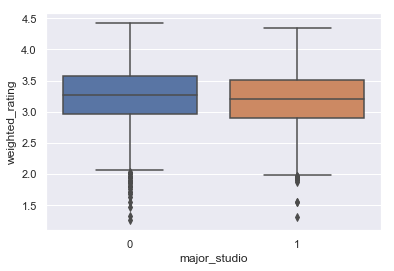

In [58]:
sns.boxplot(x = 'major_studio', y = 'weighted_rating', data = df)

### Genre Popularity: What's the relationship between genres and ratings
Based on the first chart showing that certain types of genres are more popular in terms of the production numbers, I would plot to check if the taste of movie companies aligned with the audience.

Originally, there are 20 genre types in the dataset. After merging subgenres into 10 major genres:
- `Drama`(Music/History)
- `Comedy`
- `Action`(War)
- `Thriller`(Mystery/Crime)
- `Adventure`(Western)
- `Horror`
- `Fantasy`(Science Fiction)
- `Family`
- `Animation`
- `Documentary`

*Note: TV Movie and Foreign are removed since both of them only have one data point

In [61]:
# Merge movie subgenres into major genres

def combine_genre(series):
    """Loop through the list of genres and replace the subgenres with the major types,
    and deleter two minor genres: 'TV Movie' and 'Foreign'
    """
    genre_dict = {'Music':'Drama','History':'Drama',
              'War':'Action', 
              'Crime':'Thriller','Mystery':'Thriller',
              'Western':'Adventure',
              'Science Fiction':'Fantasy'}
    try:
        for i in range(len(series)):
            if series[i] in genre_dict.keys():
                series[i] = genre_dict[series[i]]
            if series[i] == 'TV Movie':
                series.remove('TV Movie')
            if series[i] == 'Foreign':
                series.remove('Foreign')
    except IndexError:
        pass
    return list(set(series))

df['genres'] = df['genres'].apply(combine_genre)

In [62]:
# Reshape the genre columns to calculate their total production numbers

# Separate the list of genre types from genres column
genres_df = pd.concat([df['genres'].apply(pd.Series),df['id']],axis=1)
# Keep all genre types within the same column
genres_df = pd.melt(genres_df, id_vars='id',value_name='genre').drop(columns='variable').sort_values(by='id')
genres_merge = pd.merge(genres_df,df[['weighted_rating','id']], on = 'id').sort_values(by=['id'])
genres_merge = genres_merge[pd.notnull(genres_merge['genre'])]

# Count the production number of each genre
genre_count = pd.DataFrame(genres_merge.groupby('genre').count())
genre_count.reset_index(inplace = True)
genre_count.drop(columns = 'weighted_rating',inplace = True)
genre_count.columns = ['genre','count']
genre_count = genre_count.sort_values(by='count',ascending=True)

#### Filmmakers produce more Thriller and Drame movies

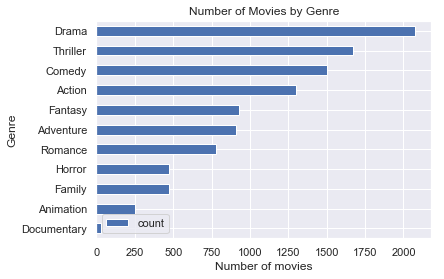

In [63]:
# Plot total number of movies vs genre
genre_count.plot.barh(x = 'genre', y = 'count')
plt.xlabel('Number of movies')
plt.ylabel('Genre')
plt.title('Number of Movies by Genre')

plt.show()

#### Thriller and Drama are easier to get high positive scores

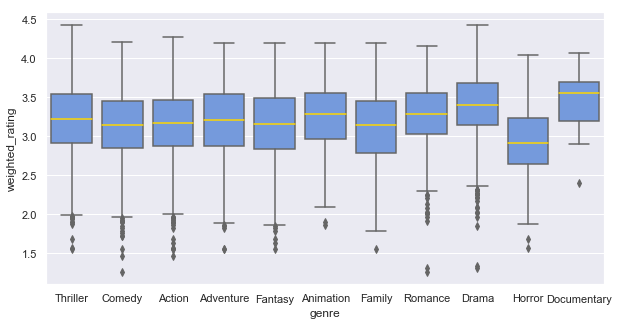

In [64]:
_ = plt.figure(figsize=(10,5))
_ = sns.boxplot(x = 'genre', y = 'weighted_rating', data = genres_merge,color = 'cornflowerblue',medianprops={'color':'gold'} )

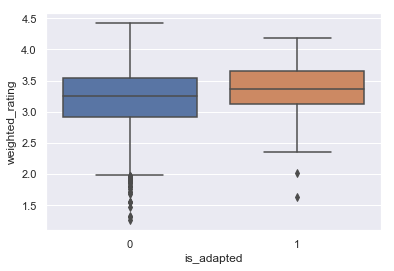

In [65]:
sns.boxplot(x = 'is_adapted', y = 'weighted_rating', data = df)

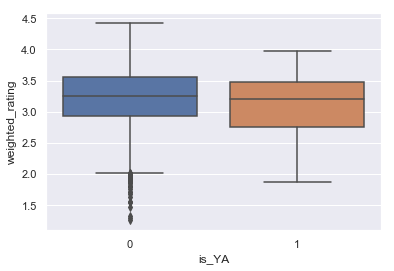

In [66]:
sns.boxplot(x = 'is_YA', y = 'weighted_rating', data = df)

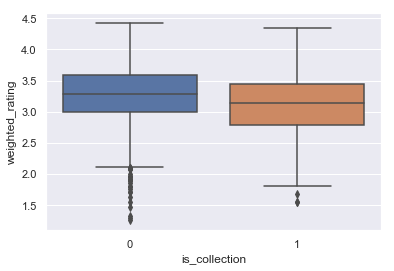

In [67]:
sns.boxplot(x = 'is_collection', y = 'weighted_rating', data = df)

## Correlation Matrix

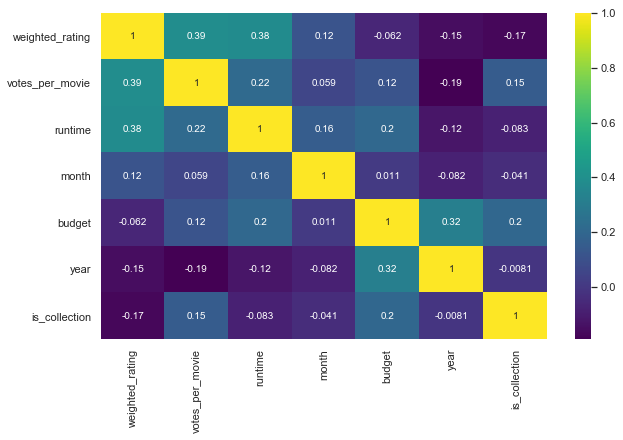

In [69]:
# select numerical variable
df_numeric = df[['weighted_rating','votes_per_movie','budget','is_collection','runtime','month','year']]

# plot coorelation matrix
k = 7 #number of variables for heatmap
cols = df_numeric.corr().nlargest(k, 'weighted_rating')['weighted_rating'].index
cm = df_numeric[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

# more than 80 or 90 
# no varialbe are highly related to each other

# Hypothesis Testing
I used hypothesis tests on 'month' and 'year', both variables related to movie release timing, to examine which one has the real influence on movie scores.


ANOVA test would be used for examining 'month', while two-sample t-test would be used for 'year'. The key assumption behind both hypothesis tests is that the data should be normally distributed. 

### Examine if the data is normally distributed

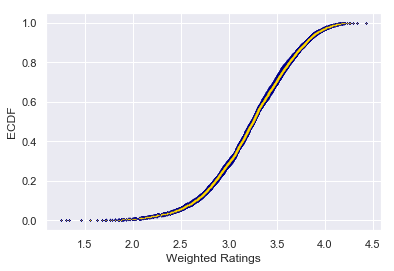

In [68]:
# Overlay the theoretical CDF of normal distribution with the empirical CDF of the real data
# to verify that the normal distribution describes the observed data

def ecdf(data):
    """Comput ECDF for a one-dimensiona array of measurements.
    """
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    
    return x, y

# Generate 50 bootstrape samples for normal distribution
for i in range(50):
    bs_sample = np.random.choice(df['weighted_rating'], size = len(df['weighted_rating']))
    # Plot a ECDF for each sample
    x, y = ecdf(bs_sample)
    _ = plt.plot(x, y, marker = '.',linestyle = 'none', c = 'darkblue', markersize = 0.5 )

    
# Plot ECDF for the original data
x, y = ecdf(df['weighted_rating'])
_ = plt.plot(x, y, marker = '.', linestyle = 'none',  c = 'gold', markersize = 0.5)

_ = plt.xlabel('Weighted Ratings')
_ = plt.ylabel('ECDF')

plt.show()

The CDF of a normal distribution computed from bootstrap samples overlay with the empirical CDF computed from real observations. It verifies the data of weighted_ratings is normally distributed, and meets the normality condition of hypothesis test.

#### Using ANOVA-Test to examine if movie scores differ among month
- Stating hypothesis
    - H0: The mean of weighted ratings are the same among movies released in 12 months.
    - H1: The mean of weighted ratings are different among movies released in 12 months.
- Deciding significance level
    - The significance level (α) is 0.05.

In [70]:
# dummy-encoding
df_new = df
df_new[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']] = pd.get_dummies(df['month'])[[1,2,3,4,5,6,7,8,9,10,11,12]]
df_new['intercept'] = 1
df_new.head()

,id,title,revenue,budget,is_collection,genres,runtime,original_language,production_companies,production_countries,...,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,intercept
0,197,Braveheart,210000000.0,72000000,0,"[Action, Drama]",177.0,en,Icon Entertainment International,United States of America,...,0,1,0,0,0,0,0,0,0,1
1,238,The Godfather,245066411.0,6000000,1,"[Thriller, Drama]",175.0,en,Paramount Pictures,United States of America,...,0,0,0,0,0,0,0,0,0,1
2,240,The Godfather: Part II,47542841.0,13000000,1,"[Thriller, Drama]",200.0,en,Paramount Pictures,United States of America,...,0,0,0,0,0,0,0,0,1,1
3,207,Dead Poets Society,235860116.0,16400000,0,[Drama],129.0,en,Touchstone Pictures,United States of America,...,0,0,1,0,0,0,0,0,0,1
4,2108,The Breakfast Club,51525171.0,1000000,0,"[Drama, Comedy]",97.0,en,Universal Pictures,United States of America,...,0,0,0,0,0,0,0,0,0,1


In [71]:
# import module
import statsmodels.api as sm

# fit and summarize OLS model
mod = sm.OLS(df_new['weighted_rating'], df_new[['intercept','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']])
results = mod.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        weighted_rating   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     10.80
Date:                Wed, 06 Nov 2019   Prob (F-statistic):           6.21e-20
Time:                        23:49:38   Log-Likelihood:                -2641.2
No. Observations:                4337   AIC:                             5306.
Df Residuals:                    4325   BIC:                             5383.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.9708      0.006    467.484      0.000       2.958       2.983
Jan            0.1706      0.027      6.369      0.000       0.118       0.223
Feb            0.1849      0.025      7.526      0.000       0.137       0.233
Mar            0.2007      0.024      8.539      0.000       0.155       0.247
Apr            0.2067      0.024      8.514      0.000       0.159       0.254
May            0.3049      0.023     13.065      0.000       0.259       0.351
Jun            0.2294      0.022     10.422      0.000       0.186       0.273
Jul            0.2053      0.023      9.026      0.000       0.161       0.250
Aug            0.1689      0.022      7.670      0.000       0.126       0.212
Sep            0.3531      0.019     18.185      0.000       0.315       0.391
Oct            0.2759      0.021     12.848      0.000       0.234       0.318
Nov            0.2800      0.023     12.095      0.000       0.235       0.325
Dec            0.3904      0.020     19.742      0.000       0.352       0.429
==============================================================================
Omnibus:                      108.714   Durbin-Watson:                   1.285
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.178
Skew:                          -0.383   Prob(JB):                     3.59e-26
Kurtosis:                       3.245   Cond. No.                     2.83e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.89e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Thought Process**: 

P-value(P >|t|) is less than the alpha value. Null hypothesis is rejected. There's statistically significant difference in scores between movies released in different months. Thus, we will pass the variable 'month' to the prediction machine since it might affect how people scores the movies.

#### Using t-test to examine if movie scores differ among years
Assuming that movies in the different periouds should receive different scores, we select two samples, one with movies released in the earlies and latest five years to perform independent t-test.

- Stating hypothesis
    - H0: The mean of weighted ratings are the **same** for two samples.
    - HA: The mean of weighted ratings are **different** for two samples.
- Deciding significance level
    - The significance level (α) is 0.05.

In [72]:
# sampling
previous_5_year = df[df['year'] > 1914 & (df['year'] < 1920)]['weighted_rating']
last_5_year = df[(df['year'] > 2012) & (df['year'] <= 2017)]['weighted_rating']

# independent t-test
from scipy import stats
t_stat, p = stats.ttest_ind(previous_5_year, last_5_year)
print ('statistics=%.3f , p=%.3f' %(t_stat,p))

# interpret via p-vaule
alpha = 0.05
if p > alpha:
    print('Accept null hypothesis that the means are equal.')
else:
    print('Reject the null hypothesis that the means are equal.')

statistics=-2.477 , p=0.013
Reject the null hypothesis that the means are equal.


**Thought Process**:

With p-value larger than alpha value, null hypothesis fails to be rejected. No statistically significant difference in scores between movies released in different years. Because the variable 'year' might be a less useful factor to predict movie scores, we dedcide to drop it.

# Dummy Encoding
Before feeding the data into prediction models, we need to drop text variables that don't fit to our project scope and convert categorical variables to numerical with dummy encoding. 

In [73]:
df.columns

Index(['id', 'title', 'revenue', 'budget', 'is_collection', 'genres',
       'runtime', 'original_language', 'production_companies',
       'production_countries', 'cast', 'votes_per_movie', 'weighted_rating',
       'director', 'month', 'year', 'is_adapted', 'is_YA', 'major_studio',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec', 'intercept'],
      dtype='object')

In [74]:
# only keep variables that will be fed into the model
df_2 = df[['budget', 'is_collection', 'genres',
       'runtime', 'original_language',
       'production_countries', 'cast', 'votes_per_movie', 'weighted_rating',
       'director', 'month', 'is_adapted', 'is_YA', 'major_studio']]

In [75]:
# for the column 'director', 'production_companies', 'production_countries', 'original_language'
# convert the values with less occurence to 'Others'
def convert_to_others(df, col, x, num):
    top = df[col].value_counts()[:num]
    if x in top:
        return x
    if x not in top:
        return 'Others'
    
df_2['director'] = df_2['director'].apply(lambda x: convert_to_others(df_2, 'director', x, 10))
df_2['production_countries'] = df_2['production_countries'].apply(lambda x: convert_to_others(df_2, 'production_countries', x, 5))
df_2['original_language'] = df_2['original_language'].apply(lambda x: convert_to_others(df_2, 'original_language', x, 5))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [76]:
# get dummy variables 
columns = ['director','production_countries', 'original_language']
prefix_dic = {'director': 'director','production_countries':'country','original_language': 'language'}
df_dummy = pd.get_dummies(df_2, columns = columns, prefix = prefix_dic)

In [77]:
# drop column 'Others' from the dataframe
df_dummy.drop(columns = ['director_Others', 'language_Others', 'country_Others'], inplace = True)

In [78]:
# dummy encoding for genre
df_genre = pd.get_dummies(pd.Series(df['genres']).apply(pd.Series).stack()).sum(level=0).drop(columns = 'Documentary')

In [79]:
# for 'cast' column, we only select top 30 movie stars with the most appearance 
# and convert the rest to 'Others'
# compute the top casts
from collections import Counter
def occurence(Series):
    cnt = Counter()
    
    def cast_dict(x):
        cast_dict = Counter()
        for cast in x:
            cast_dict[cast] += 1
        return cast_dict
    for d in Series.apply(cast_dict):
        cnt += d
    return cnt

In [80]:
top_cast = sorted(occurence(df.cast), key = occurence(df.cast).get, reverse = True) [:10]
print (top_cast)

['Robert De Niro', 'Nicolas Cage', 'Bruce Willis', 'Tom Hanks', 'Johnny Depp', 'Matt Damon', 'Samuel L. Jackson', 'Sylvester Stallone', 'Harrison Ford', 'Tom Cruise']


In [81]:
# iterate through each list
# turn each list into a set
# compare the set with the set(top_cast)
# return the elements appearing in both set

def compare_two_sets(x):
    if bool(set(x) & set(top_cast)):
        return list(set(x) & set(top_cast))
    else:
        return ['Others']
df_2['cast'] = df_2['cast'].apply(compare_two_sets)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [82]:
# dummy encoding for cast
df_cast = pd.get_dummies(pd.Series(df_2['cast']).apply(pd.Series).stack()).sum(level=0).drop(columns = 'Others')

In [83]:
# dummy encoding for month
df_month = pd.get_dummies(df['month'], drop_first = True)
df_month.rename(columns = {2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}, inplace = True)

In [84]:
# concate the dataframe
df_clean = pd.concat([df_dummy, df_cast, df_genre, df_month], axis = 1).drop(columns = ['genres','cast','month'])

In [85]:
df_clean.head()

,budget,is_collection,runtime,votes_per_movie,weighted_rating,is_adapted,is_YA,major_studio,director_Alfred Hitchcock,director_Clint Eastwood,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,72000000,0,177.0,66512,4.015094,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,6000000,1,175.0,57070,4.338309,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,13000000,1,200.0,36679,4.261279,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,16400000,0,129.0,25752,3.910587,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1000000,0,97.0,26611,3.825622,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
df_clean.shape

(4337, 59)

In [87]:
df_clean.dropna(axis = 0, how = 'any', inplace = True)

In [88]:
df_clean.isna().sum().sum()

0

# Check Correlation among Features

In [89]:
# find highly correlated features with Pearson Correlation higher than 0.7
corr_maxtric = df_clean.corr().abs()
cols = df_clean.columns
correlated_pairs = set()
for i in range(len(cols)):
    for j in range(i):
        if corr_maxtric.iloc[i,j] > 0.7:
            correlated_pairs.add((cols[i],cols[j],corr_maxtric.iloc[i,j]))
print (pd.DataFrame(correlated_pairs))

Empty DataFrame
Columns: []
Index: []


# Machine Learning Prediction

## Using decisiton tree regression

In [90]:
#  Import 'r2_score'
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit

In [91]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    #   Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

In [92]:
# split dataset in features and target variable
feature_cols = list(df_clean.columns)
feature_cols.remove('weighted_rating')
x = df_clean[feature_cols] # features
y = df_clean['weighted_rating'] # target variable

In [93]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_model_dt(x, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(n_splits=5, train_size = 0.20, random_state = 0)

    #  Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    #  Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':range(1,11)}

    #  Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    #   Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(regressor, params, scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(x, y)
 #   print "Parameter 'max_depth' is {} for the optimal model.".format(grid.get_params() )

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [94]:
fit_model_dt(x, y)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1788: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [95]:
# import modules
from sklearn.model_selection import train_test_split
# split the dataframe into two 80% for training and 20% testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [96]:
from sklearn.tree import DecisionTreeRegressor
# create decision tree regressor object
dt = DecisionTreeRegressor(max_depth=5)
# train devision tree classifer
dt.fit(x_train, y_train)
# predict the response for test dataset
y_pred = dt.predict(x_test)

In [97]:
# performance on training data
r2_score(y_train, dt.predict(x_train))

0.4592117766059448

In [98]:
# performance on test data
r2_score(y_test, y_pred)

0.3718563849381332

In [99]:
dt.feature_importances_

array([0.13942152, 0.02657394, 0.10653328, 0.45421029, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00492741, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01073736,
       0.        , 0.25759621, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [100]:
list(zip(feature_cols, dt.feature_importances_))

[('budget', 0.13942151569878117),
 ('is_collection', 0.02657393752952853),
 ('runtime', 0.10653328120404108),
 ('votes_per_movie', 0.45421028837889305),
 ('is_adapted', 0.0),
 ('is_YA', 0.0),
 ('major_studio', 0.0),
 ('director_Alfred Hitchcock', 0.0),
 ('director_Clint Eastwood', 0.0),
 ('director_Martin Scorsese', 0.0),
 ('director_Oliver Stone', 0.0),
 ('director_Ridley Scott', 0.0),
 ('director_Robert Zemeckis', 0.0),
 ('director_Steven Soderbergh', 0.0),
 ('director_Steven Spielberg', 0.0),
 ('director_Tim Burton', 0.0),
 ('director_Woody Allen', 0.0),
 ('country_Canada', 0.0),
 ('country_France', 0.0),
 ('country_Germany', 0.0),
 ('country_United Kingdom', 0.004927405791770004),
 ('country_United States of America', 0.0),
 ('language_en', 0.0),
 ('language_es', 0.0),
 ('language_fr', 0.0),
 ('language_hi', 0.0),
 ('language_ja', 0.0),
 ('Bruce Willis', 0.0),
 ('Harrison Ford', 0.0),
 ('Johnny Depp', 0.0),
 ('Matt Damon', 0.0),
 ('Nicolas Cage', 0.0),
 ('Robert De Niro', 0.0),
 ('

## Using Random Forest

In [101]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)
rfr.score(x_train, y_train) # yeilds R-squared value

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9039615559806023

In [102]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_model_rfr(x, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(n_splits=5, train_size = 0.20, random_state = 0)

    #  Create a decision tree regressor object
    rfr = RandomForestRegressor()

    #  Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':range(1,11)}

    #  Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    #   Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(rfr, params, scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(x, y)
 #   print "Parameter 'max_depth' is {} for the optimal model.".format(grid.get_params() )

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [103]:
fit_model_rfr(x, y)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1788: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimator

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [104]:
rfr = RandomForestRegressor(max_depth=7)
# train devision tree classifer
rfr.fit(x_train, y_train)
# predict the response for test dataset
y_pred = rfr.predict(x_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [105]:
# performance on training data
r2_score(y_train, rfr.predict(x_train))

0.6129422653152055

In [106]:
# performance on test data
r2_score(y_test, y_pred)

0.469943496966596

## Using GaussianProcessRegressor

In [107]:
import sklearn.gaussian_process as gp

In [108]:
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))

In [109]:
gpr = model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

In [110]:
gpr.fit(x_train, y_train)

GaussianProcessRegressor(alpha=0.1, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=10), n_restarts_optimizer=10,
             normalize_y=True, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [111]:
y_pred = gpr.predict(x_test)

In [112]:
r2_score(y_train, gpr.predict(x_train))

0.6337752737139567

In [113]:
r2_score(y_test, y_pred)

0.03310725012161542